In [3]:
import importlib

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

import functions as f

importlib.reload(f)

<module 'functions' from 'c:\\uoe_repos\\ind-maths-project-2-group-8\\functions.py'>

## Testing how we can set up the domain for the tests

#### Birds
Need to consider
- Flock size
- Flock shape (V-shape?)
- Spacing between birds
- Number of birds



#### Obstacles
Need to consider
- Number of obstaces
- Spacing of obstacles
- Grid type (even across/offset)
- 

# Bird Flocks

- Average length is 0.64m
- Wingspan is 137.5cm

Let's assume they want at least 2 m between the center of each bird

Assume that birds fly in lines with a slight V-formation

Old functions

In [4]:
def add_noise_theta(theta, eta, N):
    '''
    Update theta with a random amount of noise between -eta/2 and eta/2
    '''
    theta += eta * (np.random.rand(N, 1) - 0.5)
    
    return theta

def initialize_birds_random(N, L, v0):
    '''
    Set initial positions, direction, and velocities 
    '''
    # Bird positions
    x = np.random.rand(N, 1)*L
    y = np.random.rand(N, 1)*L

    # Bird velocities
    theta = 2 * np.pi * np.random.rand(N, 1)
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)

    return x, y, vx, vy, theta


def initialize_birds_square(N, L, v0, theta_start, eta):
    '''
    Set initial positions as a uniform placement starting at the edge of the box.
    Set direction and velocity to be uniform with a small amount of noise 
    '''
    
    # Set bird initial flock as a square
    N_per_side = int(np.sqrt(N))
    
    # Midpoint of area 
    midpoint = L//2
    
    # Define the x locations (start in centre of perimeter)
    half_length = N_per_side // 2
    start = midpoint - half_length
    x_locs = np.arange(start, start + N_per_side)
    
    # Define the y locations (start from bottom)
    y_locs = np.arange(0, N_per_side)
    
    # Define bird starting points
    # Initialise lists
    x = []
    y = []
    
    for x_loc in x_locs:
        for y_loc in y_locs:
            x.append([x_loc])
            y.append([y_loc])
    
    # Turn into numpy arrays
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    
    # Bird Angle
    # Make all birds same starting angle
    theta = np.ones((len(x),1))*theta_start
    
    # Add noise
    theta = add_noise_theta(theta, eta, N)
    
    
    # Bird velocities
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)
    
    
    return x, y, vx, vy, theta

Triangle flock shape

In [5]:
def initialize_birds_triangle(N, L, v0, theta_start, eta):
    '''
    Set initial positions as a triangle starting at the bottome edge of the simulation box.
    Set direction and velocity to be uniform with a small amount of noise 
    
    Triangle is shaped based on an angle (be an obstuse angle). Make it an obtuse isoceles triangle
    Birds should spaced by 2 m in both the x and y directions
    '''
    min_distance = 2
    top_angle = np.radians(150)

    # Properties of obtuse isoceles triangle
    bottom_angle = (np.pi - top_angle)/2

    # Initialise parameters and lists
    x, y = [], []
    total_birds = 0
    row = 0
    x_row_0 = L // 2

    # Loop through rows of triangle, starting with 1 in first row. 

    while total_birds < N:
        # y position of this row
        y_pos = -row * min_distance

        # base length of triangle in this row
        base_length = 2*abs(y_pos) / np.tan(bottom_angle)
        half_base = base_length/2
        
        # number of birds that can fit in the current row
        birds_in_row = int(base_length / min_distance) + 1

        # limit the number of birds in the row if total exceeds N
        if total_birds + birds_in_row > N:
            birds_in_row = N - total_birds
        
        # add birds around the symmetric line of triangle
        # go from left to right
        x_row_start = x_row_0 - half_base
        
        for i in range(birds_in_row):
            x.append(x_row_start + (i * min_distance))
            y.append(y_pos)
        
        # update total birds and row counters
        total_birds += birds_in_row
        row += 1

    # Turn into numpy arrays
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    
    # shift all y_pos up so birds start within the domain
    y = y + (row-1)*min_distance

    # Bird Angle
    # Make all birds the same starting angle
    theta = np.ones((len(x), 1)) * theta_start

    # Add noise to angle
    theta = add_noise_theta(theta, eta, N)

    # Bird velocities
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)
    
    return x, y, vx, vy, theta


Plot it

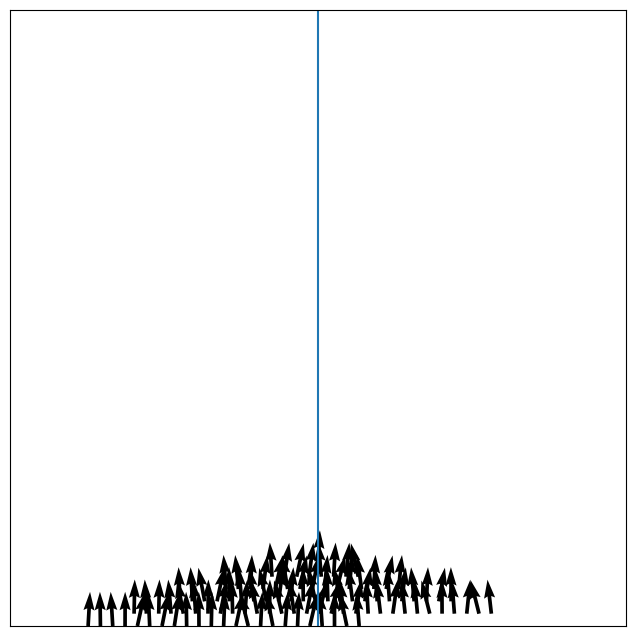

In [13]:
N = 100
L = 100

v0 = 1.0      # velocity of birds (constant)
eta = 0.5  
theta_start = np.pi/2

# Set up a figure
fig, ax = plt.subplots(figsize = (8,8))


# x, y, vx, vy, theta = initialize_birds_square(N, L, v0, theta_start, eta)


x, y, vx, vy, theta = initialize_birds_triangle(N, L, v0, theta_start, eta)


# Plot initial quivers
q = ax.quiver(x, y, vx, vy)

# Set figure parameters
ax.set(xlim=(0, L), ylim=(0, L))
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.axvline(L//2)

# Make Obstacle grids

Function to make rectangular objects

In [7]:
def make_rectangular_obstacle(x_centre, y_centre, L1, L2, n=25):
    '''
    Returns x,y points defining a rectangular obstacle
    '''
    
    # Number of points per side
    points_per_side = n // 4
    
    # Half lengths for width and height
    l1 = L1 / 2
    l2 = L2 / 2
    
    # Corners of the rectangle
    top_left = [x_centre - l1, y_centre + l2]
    top_right = [x_centre + l1, y_centre + l2]
    bottom_left = [x_centre - l1, y_centre - l2]
    bottom_right = [x_centre + l1, y_centre - l2]
    
    # Initialize lists for x and y points
    x_points = []
    y_points = []
    
    # Generate points along each side
    # Top edge (left to right)
    x_points.extend(np.linspace(top_left[0], top_right[0], points_per_side))
    y_points.extend([top_left[1]] * points_per_side)
    
    # Right edge (top to bottom)
    x_points.extend([top_right[0]] * points_per_side)
    y_points.extend(np.linspace(top_right[1], bottom_right[1], points_per_side))
    
    # Bottom edge (right to left)
    x_points.extend(np.linspace(bottom_right[0], bottom_left[0], points_per_side))
    y_points.extend([bottom_left[1]] * points_per_side)
    
    # Left edge (bottom to top)
    x_points.extend([bottom_left[0]] * points_per_side)
    y_points.extend(np.linspace(bottom_left[1], top_left[1], points_per_side))
    
    return x_points, y_points